In [1]:
import numpy as np
import pandas as pd

In [ ]:
cuda_use_gpus(1)

## Read Data ##

In [2]:
df_train = pd.read_csv('../data/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

In [3]:
df_test = pd.read_csv('../data/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

In [4]:
df_all = pd.concat((df_train, df_test))
df_all['question1'].fillna('', inplace=True)
df_all['question2'].fillna('', inplace=True)

## Create Vocab ##

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [6]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))
other_index = len(counts_vectorizer.vocabulary_)

##Prep Data##

In [7]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [8]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [9]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [10]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=1989)

##Training##

In [11]:
import keras.layers as lyr
from keras.models import Model

In [12]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 10, 100)       1000000                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 256)           365568                                       
___________________________________________________________________________________________

In [13]:
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=128, epochs=6, verbose=2)

Train on 283003 samples, validate on 121287 samples
Epoch 1/6
43s - loss: 0.5163 - val_loss: 0.4745
Epoch 2/6
44s - loss: 0.4358 - val_loss: 0.4413
Epoch 3/6
45s - loss: 0.3815 - val_loss: 0.4261
Epoch 4/6
43s - loss: 0.3348 - val_loss: 0.4221
Epoch 5/6
44s - loss: 0.2917 - val_loss: 0.4323
Epoch 6/6
45s - loss: 0.2504 - val_loss: 0.4556


##Extract Features From Model##

In [14]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [15]:
F_train = features_model.predict([X1_train, X2_train], batch_size=128)
F_val = features_model.predict([X1_val, X2_val], batch_size=128)

##Train XGBoost##

In [16]:
import xgboost as xgb

In [17]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [18]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=10)

[0]	train-logloss:0.653946	val-logloss:0.660759
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.444768	val-logloss:0.497498
[20]	train-logloss:0.341084	val-logloss:0.437497
[30]	train-logloss:0.296505	val-logloss:0.420911
[40]	train-logloss:0.265662	val-logloss:0.414312
[50]	train-logloss:0.244871	val-logloss:0.41272
[60]	train-logloss:0.228854	val-logloss:0.414049
Stopping. Best iteration:
[52]	train-logloss:0.240337	val-logloss:0.412684



##Predict Test##

In [19]:
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

In [20]:
F_test = features_model.predict([X1_test, X2_test], batch_size=128)

In [21]:
dTest = xgb.DMatrix(F_test)

In [22]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].values,
        'is_duplicate': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    }).set_index('test_id')

In [23]:
df_sub.head()

,is_duplicate
test_id,
0,0.072829
1,0.017567
2,0.299258
3,0.085807
4,0.413321


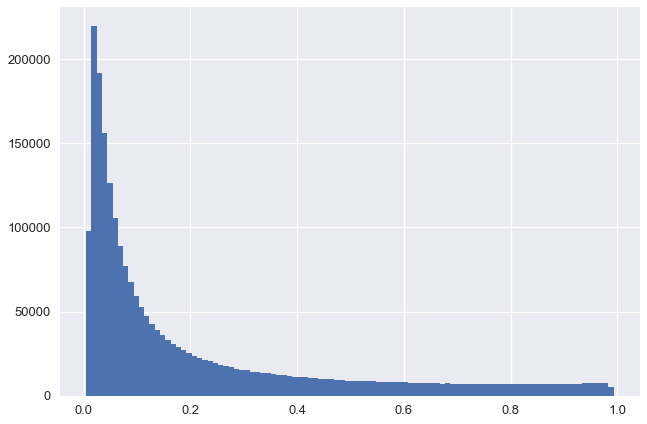

In [24]:
df_sub['is_duplicate'].hist(bins=100)